### Import libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [2]:
data= pd.read_csv("Combined_processed.csv")

In [15]:
# Inspect data
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215890 entries, 0 to 1215889
Data columns (total 48 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Seq               1215890 non-null  int64  
 1   Dur               1215890 non-null  float64
 2   sHops             1215890 non-null  float64
 3   dHops             1215890 non-null  float64
 4   TotPkts           1215890 non-null  int64  
 5   SrcPkts           1215890 non-null  int64  
 6   DstPkts           1215890 non-null  int64  
 7   TotBytes          1215890 non-null  int64  
 8   SrcBytes          1215890 non-null  int64  
 9   DstBytes          1215890 non-null  int64  
 10  Offset            1215890 non-null  int64  
 11  sMeanPktSz        1215890 non-null  float64
 12  dMeanPktSz        1215890 non-null  float64
 13  Load              1215890 non-null  float64
 14  SrcLoad           1215890 non-null  float64
 15  DstLoad           1215890 non-null  float64
 16  

#### preprocess data

In [12]:
# Numerical columns
numerical_cols= data.select_dtypes(include=[np.number]).columns.tolist()
# Categorical columns
categorical_cols = data.select_dtypes(include=[bool]).columns.tolist()

In [16]:
from sklearn.model_selection import train_test_split

# Let's assume 'Label__Malicious' is your target variable
X = data.drop(columns=["Label__Malicious"])
y = data["Label__Malicious"]

# First split into training and temp (temp will later be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Then split temp into validation and test sets (each 10% of the full dataset)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Suppose these are your categorical columns:
categorical_cols = X_train.select_dtypes(include=[object]).columns.tolist()

# Create a dictionary to store the encoders for each column
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Fit on training data only
    X_train[col] = le.fit_transform(X_train[col])
    
    # Transform validation and test sets using the same encoder
    X_val[col] = le.transform(X_val[col])
    X_test[col] = le.transform(X_test[col])
    
    encoders[col] = le  # Save encoder if you need to transform new data later


In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Fit only on training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform validation and test sets
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [34]:
X_scaled = scaler.fit_transform(X)

In [44]:
# -----------------------
# Set Up 5-Fold Cross-Validation (No Sampling)
# -----------------------
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold_scores = []

for fold, (train_index, test_index) in enumerate(skf.split(X_scaled, y), 1):
    print(f"\nFold {fold}")
    
    # Split data for this fold
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Build the Neural Network Model with regularization:
    # - L2 regularization on Dense layers
    # - Dropout layers for additional regularization
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(0.001), 
              input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # For binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model with validation_data set to the test set to track validation loss
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=20,
                        batch_size=32,
                        verbose=1)  # Change verbose=1 to see training progress
    
    # Evaluate on the test set for this fold
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Fold {fold} Accuracy: {accuracy:.4f}")
    fold_scores.append(accuracy)
    
    # Plot the training and validation loss for this fold
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold} Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



Fold 1
Epoch 1/20
 7060/25332 [=======>......................] - ETA: 29s - loss: 0.0454 - accuracy: 0.9969

KeyboardInterrupt: 

# Bringing everything together

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For feature selection
from sklearn.feature_selection import SelectKBest, chi2

# For encoding and scaling
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# For building the neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

In [2]:
# Load the Dataset
data = pd.read_csv("Combined_processed.csv")

### Data Cleaning

In [3]:
# a. Drop columns with >90% zeros
zero_ratio = (data == 0).sum() / data.shape[0]
columns_to_drop_zero = zero_ratio[zero_ratio > 0.9].index.tolist()
print("Dropping columns with >90% zeros:", columns_to_drop_zero)
data = data.drop(columns=columns_to_drop_zero)

# b. Drop columns with any null values
data = data.dropna(axis=1)

# c. Drop columns that are constant (only one unique value)
data = data.loc[:, data.nunique() > 1]

# d. Drop obviously irrelevant features (e.g., source/destination IPs/ports)
columns_to_drop_irrelevant = [
    'SrcIP', 'DstIP', 'SrcPort', 'DstPort',
    'sVid_', 'dVid_', 'SrcTCPBase_', 'DstTCPBase_', 'Attack Type_'
]
data = data.drop(columns=[col for col in columns_to_drop_irrelevant if col in data.columns], errors='ignore')

Dropping columns with >90% zeros: ['Loss', 'SrcLoss', 'DstLoss', 'pLoss', 'sTos_', 'dTos_', 'Proto_icmp', 'State_ECO', 'State_FIN', 'State_RST']


In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215890 entries, 0 to 1215889
Data columns (total 33 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Seq               1215890 non-null  int64  
 1   Dur               1215890 non-null  float64
 2   sHops             1215890 non-null  float64
 3   dHops             1215890 non-null  float64
 4   TotPkts           1215890 non-null  int64  
 5   SrcPkts           1215890 non-null  int64  
 6   DstPkts           1215890 non-null  int64  
 7   TotBytes          1215890 non-null  int64  
 8   SrcBytes          1215890 non-null  int64  
 9   DstBytes          1215890 non-null  int64  
 10  Offset            1215890 non-null  int64  
 11  sMeanPktSz        1215890 non-null  float64
 12  dMeanPktSz        1215890 non-null  float64
 13  Load              1215890 non-null  float64
 14  SrcLoad           1215890 non-null  float64
 15  DstLoad           1215890 non-null  float64
 16  

In [5]:
print(data.columns)

Index(['Seq', 'Dur', 'sHops', 'dHops', 'TotPkts', 'SrcPkts', 'DstPkts',
       'TotBytes', 'SrcBytes', 'DstBytes', 'Offset', 'sMeanPktSz',
       'dMeanPktSz', 'Load', 'SrcLoad', 'DstLoad', 'Rate', 'SrcRate',
       'DstRate', 'TcpRtt', 'SynAck', 'AckDat', 'sTtl_', 'dTtl_', 'SrcWin_',
       'DstWin_', 'Proto_tcp', 'Proto_udp', 'Cause_Status', 'State_CON',
       'State_INT', 'State_REQ', 'Label__Malicious'],
      dtype='object')


In [4]:
# Encode Categorical Variables
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    encoders[col] = le

# Separate Features & Target, then Apply Feature Selection
target_col = "Label__Malicious"
if target_col not in data.columns:
    raise ValueError(f"Target column '{target_col}' not found in the dataset!")
    
y = data[target_col]
X = data.drop(columns=[target_col])

### Feature Selection using pearson correlation

In [5]:
# Feature Selection Using Pearson Correlation
pearson_corr = X.corrwith(y)
print("\nPearson Correlation with Target:")
print(pearson_corr.sort_values(ascending=False))

# Select features with absolute correlation > threshold (e.g., 0.1)
threshold = 0.1
selected_features = pearson_corr[abs(pearson_corr) > threshold].index.tolist()
print(f"\nSelected Features based on Pearson correlation (|corr| > {threshold}):")
print(selected_features)
X = X[selected_features]


Pearson Correlation with Target:
Proto_tcp       0.378910
AckDat          0.293770
TcpRtt          0.195211
Dur             0.162825
dTtl_           0.138945
dMeanPktSz      0.108514
Cause_Status    0.105866
State_CON       0.056073
State_REQ       0.025951
SynAck          0.023518
DstLoad         0.005740
Load            0.005732
SrcRate         0.005529
DstRate         0.005333
Rate            0.004231
SrcLoad         0.003917
DstWin_         0.001312
DstPkts        -0.032770
DstBytes       -0.034669
SrcWin_        -0.089969
TotPkts        -0.099134
SrcPkts        -0.111448
TotBytes       -0.117561
SrcBytes       -0.121247
sHops          -0.162490
sMeanPktSz     -0.175133
State_INT      -0.196258
dHops          -0.233123
Proto_udp      -0.289052
sTtl_          -0.419852
Offset         -0.456065
Seq            -0.527940
dtype: float64

Selected Features based on Pearson correlation (|corr| > 0.1):
['Seq', 'Dur', 'sHops', 'dHops', 'SrcPkts', 'TotBytes', 'SrcBytes', 'Offset', 'sMeanPkt

### Feature Selection using Chi-square test

In [6]:

# Optional: Chi-square Test (for non-negative features)
# Chi-square test requires non-negative values. If needed, ensure that features are non-negative.
chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(X, y)
chi2_scores = chi2_selector.scores_
chi2_pvalues = chi2_selector.pvalues_
chi2_results = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Score': chi2_scores,
    'p-value': chi2_pvalues
}).sort_values(by='Chi2 Score', ascending=False)
print("\nChi-square Test Results:")
print(chi2_results)



Chi-square Test Results:
         Feature    Chi2 Score  p-value
7         Offset  2.339150e+12      0.0
0            Seq  1.198481e+10      0.0
6       SrcBytes  4.224510e+09      0.0
5       TotBytes  4.197740e+09      0.0
9     dMeanPktSz  1.070118e+07      0.0
8     sMeanPktSz  1.069171e+07      0.0
12         sTtl_  7.949852e+06      0.0
13         dTtl_  1.433668e+06      0.0
4        SrcPkts  1.383413e+06      0.0
3          dHops  1.305621e+06      0.0
2          sHops  2.024878e+05      0.0
14     Proto_tcp  1.345595e+05      0.0
1            Dur  6.756040e+04      0.0
17     State_INT  3.417022e+04      0.0
15     Proto_udp  2.613902e+04      0.0
16  Cause_Status  5.460666e+03      0.0
10        TcpRtt  3.013776e+03      0.0
11        AckDat  2.849205e+03      0.0


### Data preparation

In [7]:
import joblib

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Split into Train (60%), Validation (20%), and Test (20%) Sets
# First, split into 60% train and 40% temporary
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42, stratify=y)
# Then, split temporary set equally into validation and test (20% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [11]:
print(y_test)

71792       True
1000203     True
844730      True
1167840    False
805712      True
           ...  
575525      True
1151237     True
629888      True
871497      True
419810     False
Name: Label__Malicious, Length: 243178, dtype: bool


In [15]:
print(len(y_test))
print(len(X_test))

243178
243178


In [16]:
print(X_test)

[[-0.56918719 -0.80698017 -0.33631962 ...  0.58859231 -1.22292317
   1.64273239]
 [-0.79517472 -0.80698017 -0.33631962 ...  0.58859231  0.81771286
  -0.60874188]
 [-0.59375566  0.72383056 -0.33631962 ...  0.58859231  0.81771286
  -0.60874188]
 ...
 [-0.46874241 -0.80698017 -0.33631962 ... -1.69896884  0.81771286
  -0.60874188]
 [-0.44372388  0.71686903 -0.33631962 ...  0.58859231  0.81771286
  -0.60874188]
 [ 1.53422291 -0.80698017 -0.33631962 ...  0.58859231  0.81771286
  -0.60874188]]


In [9]:
test_data=pd.DataFrame(X_test)
# test_data['y']=y_test
print(test_data)


              0         1         2         3         4         5         6   \
0      -0.569187 -0.806980 -0.336320  0.537658 -0.146687 -0.119436 -0.101803   
1      -0.795175 -0.806980 -0.336320  0.537658 -0.146687 -0.119436 -0.101803   
2      -0.593756  0.723831 -0.336320  0.537658 -0.092375 -0.118044 -0.100086   
3       0.116983 -0.806980  1.248085  0.537658 -0.146687 -0.118376 -0.100495   
4      -0.317705 -0.806980 -0.336320  0.537658 -0.146687 -0.119436 -0.101803   
...          ...       ...       ...       ...       ...       ...       ...   
243173 -1.016741 -0.806980 -0.336320 -1.858232 -0.200999 -0.118641 -0.103519   
243174 -0.160128 -0.806980 -0.336320 -1.858232 -0.146687 -0.116454 -0.100822   
243175 -0.468742 -0.806980 -0.336320 -1.858232 -0.146687 -0.116454 -0.100822   
243176 -0.443724  0.716869 -0.336320  0.537658 -0.092375 -0.118044 -0.100086   
243177  1.534223 -0.806980 -0.336320  0.537658 -0.146687 -0.119436 -0.101803   

              7         8         9    

In [10]:
test_data = test_data.reset_index(drop=True)

In [11]:
test_data["y"] = pd.Series(y_test).reset_index(drop=True)

In [12]:
print(test_data)

               0         1         2         3         4         5         6  \
0      -0.569187 -0.806980 -0.336320  0.537658 -0.146687 -0.119436 -0.101803   
1      -0.795175 -0.806980 -0.336320  0.537658 -0.146687 -0.119436 -0.101803   
2      -0.593756  0.723831 -0.336320  0.537658 -0.092375 -0.118044 -0.100086   
3       0.116983 -0.806980  1.248085  0.537658 -0.146687 -0.118376 -0.100495   
4      -0.317705 -0.806980 -0.336320  0.537658 -0.146687 -0.119436 -0.101803   
...          ...       ...       ...       ...       ...       ...       ...   
243173 -1.016741 -0.806980 -0.336320 -1.858232 -0.200999 -0.118641 -0.103519   
243174 -0.160128 -0.806980 -0.336320 -1.858232 -0.146687 -0.116454 -0.100822   
243175 -0.468742 -0.806980 -0.336320 -1.858232 -0.146687 -0.116454 -0.100822   
243176 -0.443724  0.716869 -0.336320  0.537658 -0.092375 -0.118044 -0.100086   
243177  1.534223 -0.806980 -0.336320  0.537658 -0.146687 -0.119436 -0.101803   

               7         8         9   

In [23]:
print(test_data["y"])

0          True
1          True
2          True
3         False
4          True
          ...  
243173     True
243174     True
243175     True
243176     True
243177    False
Name: y, Length: 243178, dtype: bool


In [24]:
test_data.to_csv("TestData.csv")

In [11]:
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved as 'scaler.pkl'")

Scaler saved as 'scaler.pkl'


In [ ]:
# print(f"\nShapes:\nTrain: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")
# print(f"\nShapes:\nTrain: {y_train.shape}, Validation: {y_val.shape}, Test: {y_test.shape}")


Shapes:
Train: (729534, 19), Validation: (243178, 19), Test: (243178, 19)

Shapes:
Train: (729534,), Validation: (243178,), Test: (243178,)


### Normalize/Scale the Features and encode label

In [ ]:
# print(X_test)

[[-0.56918719 -0.80698017 -0.33631962 ...  0.58859231 -1.22292317
   1.64273239]
 [-0.79517472 -0.80698017 -0.33631962 ...  0.58859231  0.81771286
  -0.60874188]
 [-0.59375566  0.72383056 -0.33631962 ...  0.58859231  0.81771286
  -0.60874188]
 ...
 [-0.46874241 -0.80698017 -0.33631962 ... -1.69896884  0.81771286
  -0.60874188]
 [-0.44372388  0.71686903 -0.33631962 ...  0.58859231  0.81771286
  -0.60874188]
 [ 1.53422291 -0.80698017 -0.33631962 ...  0.58859231  0.81771286
  -0.60874188]]


In [ ]:
#print(y_train)

1060752    False
794047      True
851251      True
595065      True
286790     False
           ...  
136778      True
840737      True
929654      True
331776     False
706469      True
Name: Label__Malicious, Length: 729534, dtype: bool


## Build & Train the Neural Network with Regularization

In [24]:
from tensorflow.keras.layers import BatchNormalization, Activation

In [25]:
model = Sequential([
    # First layer: Dense + BatchNorm + Activation + Dropout
    Dense(64, use_bias=False, kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),
    
    # Second layer: Dense + BatchNorm + Activation + Dropout
    Dense(32, use_bias=False, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),
    
    # Output layer remains unchanged
    Dense(1, activation='sigmoid')  # For binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1152      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2048      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

In [26]:
# Train the model with validation monitoring
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=20, 
                    batch_size=32,
                    verbose=1)

Epoch 1/20
22798/22798 [==============================] - 75s 3ms/step - loss: 0.0842 - accuracy: 0.9792 - val_loss: 0.0442 - val_accuracy: 0.9911
Epoch 2/20
22798/22798 [==============================] - 75s 3ms/step - loss: 0.0654 - accuracy: 0.9838 - val_loss: 0.0459 - val_accuracy: 0.9918
Epoch 3/20
22798/22798 [==============================] - 77s 3ms/step - loss: 0.0633 - accuracy: 0.9845 - val_loss: 0.0381 - val_accuracy: 0.9916
Epoch 4/20
22798/22798 [==============================] - 82s 4ms/step - loss: 0.0609 - accuracy: 0.9850 - val_loss: 0.0370 - val_accuracy: 0.9914
Epoch 5/20
22798/22798 [==============================] - 73s 3ms/step - loss: 0.0605 - accuracy: 0.9854 - val_loss: 0.0408 - val_accuracy: 0.9928
Epoch 6/20
22798/22798 [==============================] - 132s 6ms/step - loss: 0.0606 - accuracy: 0.9853 - val_loss: 0.0362 - val_accuracy: 0.9942
Epoch 7/20
22798/22798 [==============================] - 94s 4ms/step - loss: 0.0603 - accuracy: 0.9854 - val_loss: 

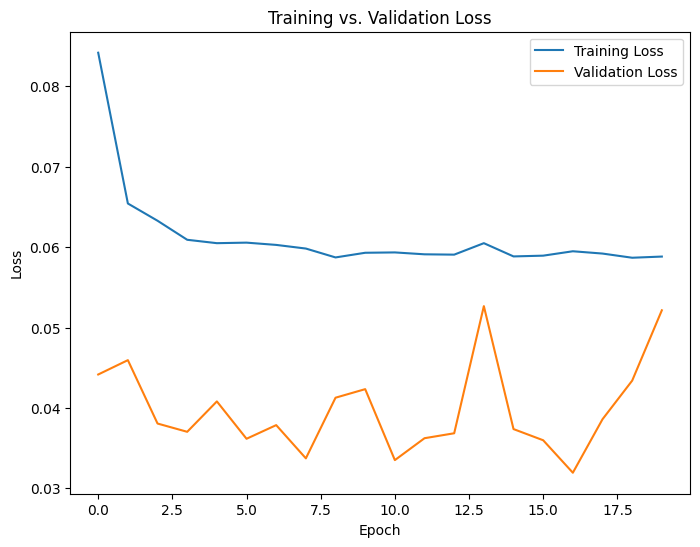

In [27]:
#Plot Training and Validation Loss Curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Evaluate the Model on the Test Set

In [28]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.0567
Test Accuracy: 0.9921


### Save the model

In [ ]:
model.save("neural_net_model.h5")

## Confusion metrics

In [13]:
model = tf.keras.models.load_model("neural_net_model.h5")

In [14]:
from sklearn.metrics import confusion_matrix, f1_score

In [15]:

y_pred_prob = model.predict(X_test)

if y_pred_prob.shape[1] == 1 or len(y_pred_prob.shape) == 1:
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
else:
    # For multi-class classification with softmax
    y_pred = np.argmax(y_pred_prob, axis=1)

# Ensure y_test is also in the right format
if len(y_test.shape) != 1:
    y_test = np.argmax(y_test, axis=1)


7600/7600 [==============================] - 10s 1ms/step


In [16]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# F1-score (macro averages over classes)
f1 = f1_score(y_test, y_pred, average='macro')
print("F1 Score (Macro):", f1)

# False Positives (per class)
false_positives = cm.sum(axis=0) - np.diag(cm)
print("False Positives per class:", false_positives)

Confusion Matrix:
 [[ 93967   1581]
 [   335 147295]]
F1 Score (Macro): 0.99172294769662
False Positives per class: [ 335 1581]
